In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
f = open('gFunctions.pcl','rb')
gSTAR = pickle.load(f)
gSTARS = pickle.load(f)
Tfunc = pickle.load(f)
f.close()

In [3]:
@np.vectorize
def H(T):
    MP = 1.22*10**19
    rhoRad = (np.pi**2/30)*gSTAR(T)*T** 4  # thermal bath's energy density    
    H = np.sqrt(8*np.pi*rhoRad/3)/MP
    
    return H

@np.vectorize
def nEQ(T,dof,mass):
    """Returns the equilibrium number density at temperature T. Returns zero for non-thermal components"""

    Zeta3 = zetac(3.) + 1.

    x = T/mass
    if x < 0.1:
        neq = mass**3*(x/(2*np.pi))**(3./2.)*np.exp(-1/x)*(1. + (15./8.)*x + (105./128.)*x**2) #Non-relativistic
    elif x < 1.5:            
        neq = mass**3*x*kn(2,1/x)/(2*np.pi**2) #Non-relativistic/relativistic
    else:
        if dof > 0: neq = Zeta3*T**3/np.pi**2   #Relativistic Bosons
        if dof < 0: neq = (3./4.)*Zeta3*T**3/np.pi**2   #Relativistic Fermions

    neq = neq*abs(dof)
    return neq


In [4]:
fileA = 'result_noCRate.dat'
fileB = '../BoltzmannEqs_new/result_noCRate.dat'

In [5]:
with open(fileA,'r') as f:
    omegaA = eval([l for l in f.readlines() if 'DM' in l and l[0] == '#'][0].split('Omega h^2 (@TF) =')[-1])
with open(fileB,'r') as f:
    omegaB = eval([l for l in f.readlines() if 'DM' in l and l[0] == '#'][0].split('Omega h^2 (@TF) =')[-1])    

In [6]:
skiplines = 10
dA = np.genfromtxt(fileA,names=True,skip_header=skiplines)
dB = np.genfromtxt(fileB,names=True,skip_header=skiplines)

In [7]:
print(dA.dtype.names)

('x', 'T', 'R', 'S', 'n_DM', 'rho_DM', 'n_Mediator', 'rho_Mediator')


In [8]:
dataList = [dA,dB]
for i,d in enumerate(dataList):
    newtype = np.dtype(d.dtype.descr + [('H', '<f8'),('s','<f8'),('neq_DM', '<f8'),('neq_Mediator', '<f8')])
    newdata = np.zeros(d.shape, dtype=newtype)
    for name in d.dtype.names:
        newdata[name] = d[name]
    newdata['H'] = H(d['T'])
    newdata['s'] = gSTARS(d['T'])*(d['T']**3)
    newdata['neq_DM'] = nEQ(d['T'],-2,500.)
    newdata['neq_Mediator'] = nEQ(d['T'],6,510.)
    dataList[i] = newdata
    
dA,dB = dataList

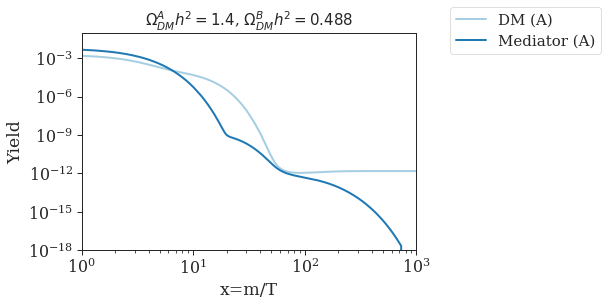

In [14]:
plt.plot(500./dA['T'],dA['n_DM']/dA['s'],label='DM (A)',linewidth=2)
plt.plot(500./dA['T'],dA['n_Mediator']/dA['s'],label='Mediator (A)',linewidth=2)
# plt.plot(500./dB['T'],dB['n_Mediator']/dB['s'],'--',label='Mediator (B)',linewidth=2)
# plt.plot(500./dB['T'],dB['n_DM']/dB['s'],'--',label='DM (B)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
plt.ylim(1e-18,1e-1)
plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\Omega_{DM}^A h^2 = %1.3g$, $\Omega_{DM}^B h^2 = %1.3g$' %(omegaA,omegaB),fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

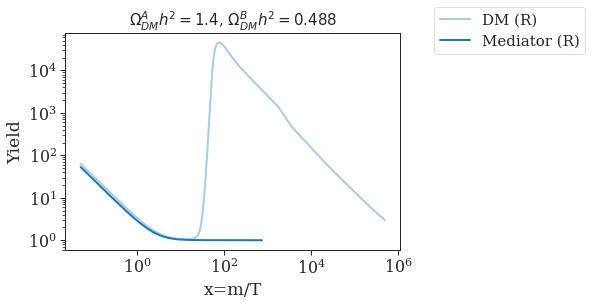

In [18]:
plt.plot(500./dA['T'],dA['rho_DM']/(500.*dA['n_DM']),label='DM (R)',linewidth=2)
plt.plot(500./dA['T'],dA['rho_Mediator']/(510.*dA['n_Mediator']),label='Mediator (R)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
# plt.ylim(1e-18,1e-1)
# plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\Omega_{DM}^A h^2 = %1.3g$, $\Omega_{DM}^B h^2 = %1.3g$' %(omegaA,omegaB),fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

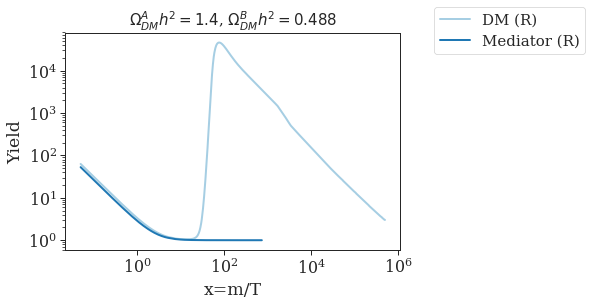

In [17]:
plt.plot(500./dB['T'],dB['rho_DM']/(500*dB['n_DM']),label='DM (R)',linewidth=2)
plt.plot(500./dB['T'],dB['rho_Mediator']/(510*dB['n_Mediator']),label='Mediator (R)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
# plt.ylim(1e-18,1e-1)
# plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\Omega_{DM}^A h^2 = %1.3g$, $\Omega_{DM}^B h^2 = %1.3g$' %(omegaA,omegaB),fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

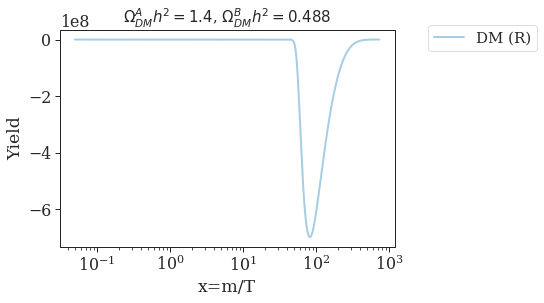

In [33]:
einj = 0.5*(1+500**2/510**2)
width = 2.49e-15
Ri = dA['rho_DM']/dA['n_DM']
Rj = dA['rho_Mediator']/dA['n_Mediator']
# plt.plot(500./dA['T'],width*510*(einj-500/510.)*(dA['n_Mediator']/dA['n_DM'])/dA['H'],
#          label='DM (R)',linewidth=2)
plt.plot(500./dA['T'],width*510*(einj-Ri/Rj)*(dA['n_Mediator']/dA['n_DM'])/dA['H'],
         label='DM (R)',linewidth=2)

plt.xscale('log')
# plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
# plt.ylim(1e-10,1e1)
# plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\Omega_{DM}^A h^2 = %1.3g$, $\Omega_{DM}^B h^2 = %1.3g$' %(omegaA,omegaB),fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()